In [83]:
pwd

'c:\\Users\\22967\\Documents\\Python env\\Competitions_files\\Zindi\\Adbot Ad Engagement Forecasting Challenge'

In [84]:
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import datetime as dt
import time

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [85]:
def wrangle(data_path):
    
    df = pd.read_csv(data_path)
    
    # Convert the currency to USD for all of them
    df.loc[df["currency"] == "USD", "cost_zar"] = df["cost"] * 19.18
    df.loc[df["currency"] != "USD", "cost_zar"] = df["cost"]
    
    drop_cols = ["call_type", "cost", 'call_status', "ad_description_len", "conversions", "conversions_calls", "start_time", "duration", "headline1_len", "headline2_len", "end_time", "display_location", "currency"]
    df.drop(columns=drop_cols, inplace=True)
    
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    
    # Substract the data in two : campains data and ad_characteristics
    #ad_characteristics = df[["ID", "date", "ad_description_len"]]
    work_data = df[["ID", "date", "clicks", "ad_type", "impressions"]]

    # Groupping by class
    #ad_characteristics = round(ad_characteristics.groupby(["ID", "date"]).mean()+0.3,0)
    work_data = work_data.groupby(["ID", "date"]).sum()

    # Setting new index for each group
    #ad_characteristics = ad_characteristics.reset_index().set_index("date")
    work_data = work_data.reset_index().set_index("date")

    # Resample each group
    #ad_characteristics = ad_characteristics.groupby("ID").resample("D").mean().fillna(method = "bfill")
    data = work_data.groupby("ID").resample("D").sum().fillna(method='bfill')
    
    # Join the data
    #data = work_data.join(ad_characteristics)
    
    # Create new variables for ad_type
    data["EXPANDED_TEXT_AD"] = data["ad_type"].str.contains("EXPANDED_TEXT_AD")
    data["EXPANDED_DYNAMIC_SEARCH_AD"] = data["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD")
    data["RESPONSIVE_SEARCH_AD"] = data["ad_type"].str.contains("RESPONSIVE_SEARCH_AD")
    data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].fillna(False)
    
    # Dropping ad_type from the cleaned database
    data.drop(columns="ad_type", inplace=True)
    data.index = data.index.droplevel(0).sort_values()
    data= data[data["ID"]!=0]
    return data

In [86]:
daily_clicks = wrangle("Data/Train.csv")
daily_clicks.head()

,ID,clicks,impressions,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,,
2020-01-01,ID_5da86e71bf5dee4cf5047046,36.0,393.0,True,False,False
2020-01-02,ID_5da86e71bf5dee4cf5047046,50.0,395.0,True,False,False
2020-01-03,ID_5da86e71bf5dee4cf5047046,54.0,404.0,True,False,False
2020-01-04,ID_5da86e71bf5dee4cf5047046,47.0,476.0,True,False,False
2020-01-05,ID_5da86e71bf5dee4cf5047046,59.0,466.0,True,False,False


In [87]:
"""daily_clicks["dates"] = daily_clicks.index
daily_clicks[["Year", "month", "day"]] = daily_clicks["dates"].astype(str).str.split("-", expand=True)
daily_clicks.drop(columns="dates", inplace=True)
daily_clicks.head()"""

'daily_clicks["dates"] = daily_clicks.index\ndaily_clicks[["Year", "month", "day"]] = daily_clicks["dates"].astype(str).str.split("-", expand=True)\ndaily_clicks.drop(columns="dates", inplace=True)\ndaily_clicks.head()'

In [88]:
client_daily_clicks = daily_clicks.reset_index().set_index(["ID", "date"])
client_daily_clicks.head()

clicks  impressions  EXPANDED_TEXT_AD  \
ID                          date                                                
ID_5da86e71bf5dee4cf5047046 2020-01-01    36.0        393.0              True   
                            2020-01-02    50.0        395.0              True   
                            2020-01-03    54.0        404.0              True   
                            2020-01-04    47.0        476.0              True   
                            2020-01-05    59.0        466.0              True   

                                        EXPANDED_DYNAMIC_SEARCH_AD  \
ID                          date                                     
ID_5da86e71bf5dee4cf5047046 2020-01-01                       False   
                            2020-01-02                       False   
                            2020-01-03                       False   
                            2020-01-04                       False   
                            2020-01-05                       False   

                                        RESPONSIVE_SEARCH_AD  
ID                          date                              
ID_5da86e71bf5dee4cf5047046 2020-01-01                 False  
                            2020-01-02                 False  
                            2020-01-03                 False  
                            2020-01-04                 False  
                            2020-01-05                 False

<Axes: xlabel='date'>

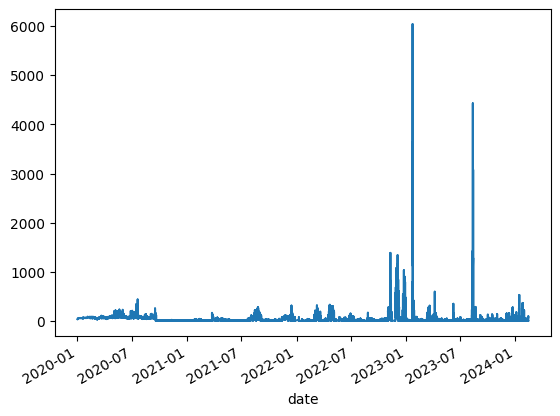

In [89]:
daily_clicks["clicks"].plot()

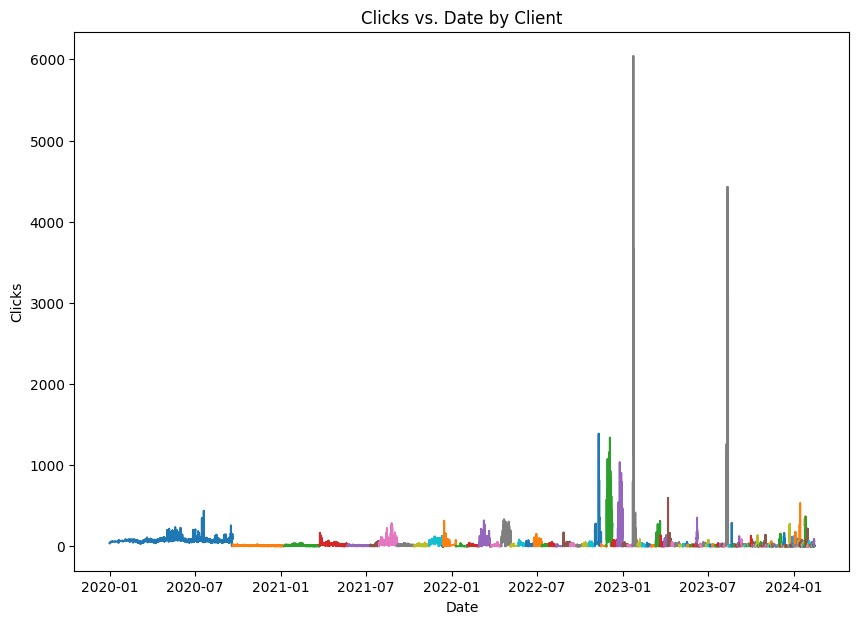

In [90]:
unique_clients = daily_clicks['ID'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Iterate through unique items and plot sales data for each item
for client in unique_clients:
    client_data = daily_clicks[daily_clicks['ID'] == client]
    ax.plot(client_data.index, client_data['clicks'], label=f'Client {client}')

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Clicks')
ax.set_title('Clicks vs. Date by Client');

In [91]:
daily_clicks['ID'].unique()

array(['ID_5da86e71bf5dee4cf5047046', 'ID_5e43c29e6279884e2827d894',
       'ID_5e4e7b480e374330ee151305', 'ID_5e8ad56cd4090270567b6c58',
       'ID_5e8b4f12d8709943490cd775', 'ID_5ebe73c4beb2212d415f6e56',
       'ID_5ee74f25f865a8154966b412', 'ID_5eebc5be7bcfa265595eb987',
       'ID_5f2ac3529666de2cdf5ae855', 'ID_5f3cdce8c0440e2c5902dd59',
       'ID_5f436d32c620230547446af4', 'ID_5f439a30fcc0f575b674bb95',
       'ID_5f4514323f494e4a2a5eb273', 'ID_5f9e5f1c691b48189c22aac6',
       'ID_5fa3dab4394cd16b000ec5fc', 'ID_5fc1263767e20c14590941ed',
       'ID_5fd88b10425b32098417a3d4', 'ID_600d8eaaf5c7660c0b1f0773',
       'ID_6017e410f7384a78e600da18', 'ID_602b729b3f4128452c1c2f64',
       'ID_602cfab1d7768d79aa6629b4', 'ID_604752a9861a02467a27c054',
       'ID_60475eaac98ea30d727b7385', 'ID_6047b0d4c59eff5af82a57ee',
       'ID_606f34aef59df516866d0ab1', 'ID_6083bd8472c70c3d1869bc68',
       'ID_608a6897d96a507cd36c935d', 'ID_608a6ad834a94a4eb8742899',
       'ID_60e556f789173d61d07e329

In [92]:
data_to_work = daily_clicks[daily_clicks["ID"]=="ID_5da86e71bf5dee4cf5047046"]
data_to_work = data_to_work.drop("ID", axis =1)
data_to_work = data_to_work.resample("D").sum().fillna("bfill")
data_to_work["EXPANDED_TEXT_AD"] = data_to_work["EXPANDED_TEXT_AD"].apply(lambda row: 1 if row>1 else row)
data_to_work["EXPANDED_DYNAMIC_SEARCH_AD"]= data_to_work["EXPANDED_DYNAMIC_SEARCH_AD"].apply(lambda row: 1 if row>1 else row)
data_to_work["RESPONSIVE_SEARCH_AD"]= data_to_work["RESPONSIVE_SEARCH_AD"].apply(lambda row: 1 if row>1 else row)
data_to_work.head()

,clicks,impressions,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,
2020-01-01,36.0,393.0,1,0,0
2020-01-02,50.0,395.0,1,0,0
2020-01-03,54.0,404.0,1,0,0
2020-01-04,47.0,476.0,1,0,0
2020-01-05,59.0,466.0,1,0,0


In [93]:
data_to_work.clicks.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14',
               '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18',
               '2020-09-19', '2020-09-20'],
              dtype='datetime64[ns]', name='date', length=264, freq='D')

<Axes: xlabel='date'>

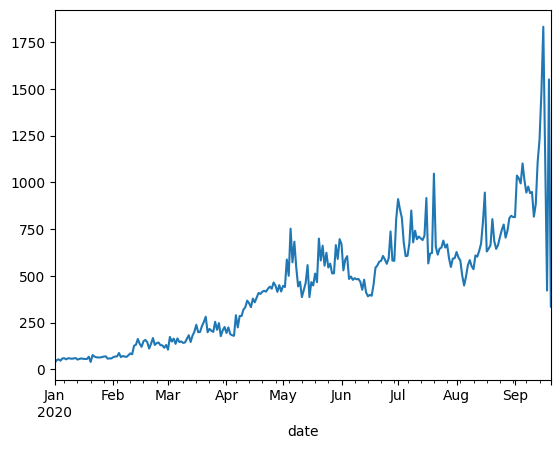

In [94]:
data_to_work.clicks.plot()

<Figure size 640x480 with 0 Axes>

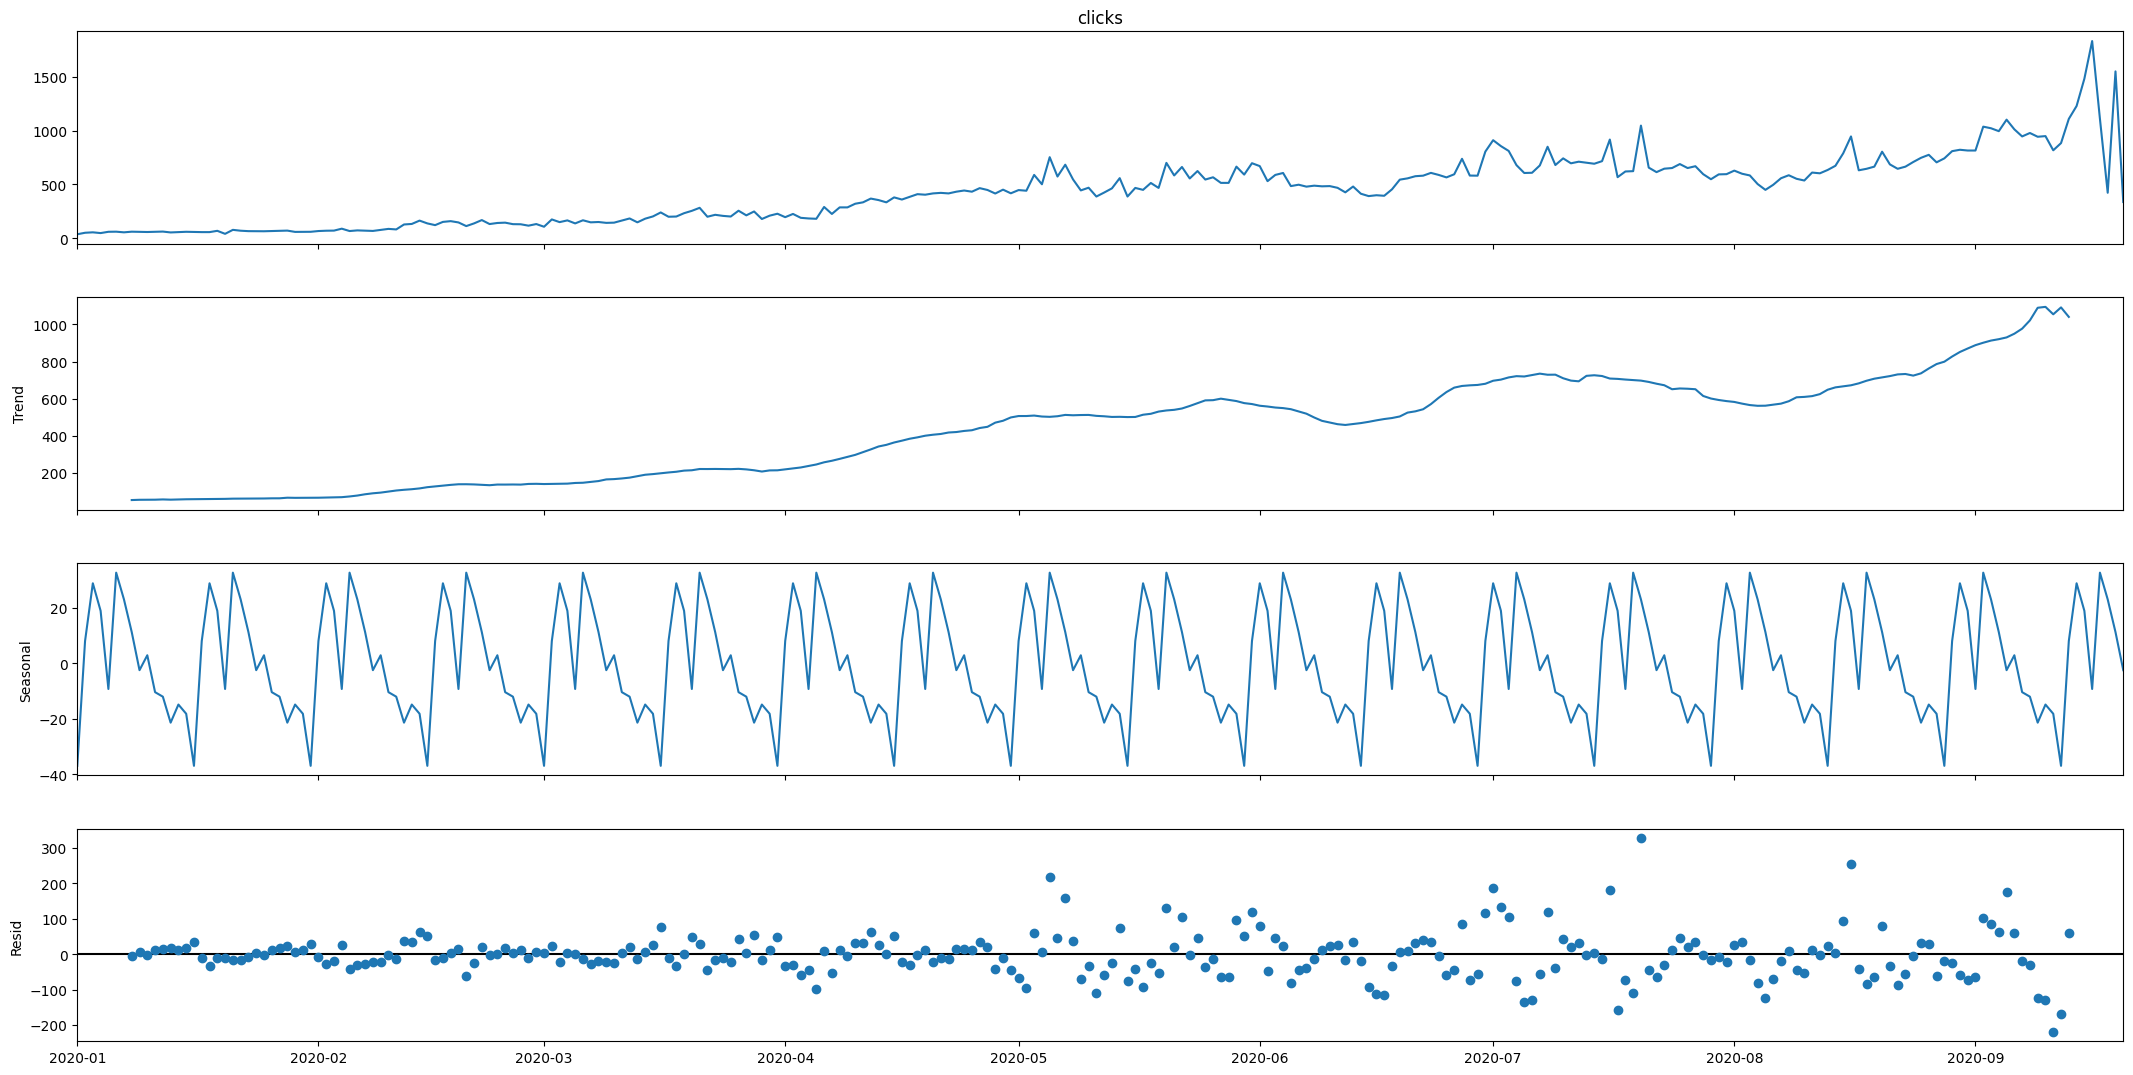

In [95]:
result = seasonal_decompose(data_to_work['clicks'], model="additive", period = 15)
fig = plt.figure()  
fig = result.plot()
fig.set_size_inches(24, 12);

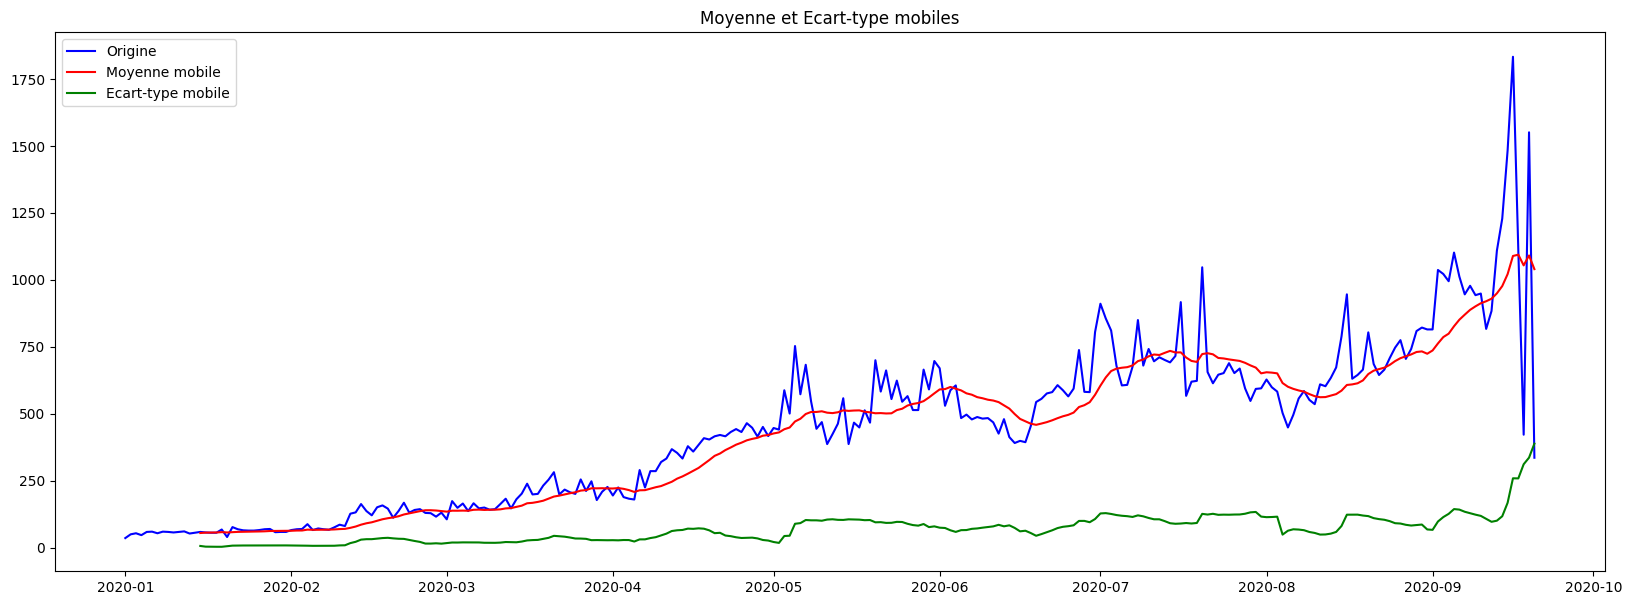

In [96]:
rolling_mean = data_to_work["clicks"].rolling(window = 15).mean()
rolling_std = data_to_work["clicks"].rolling(window = 15).std()
plt.figure(figsize=(20, 7))
plt.plot(data_to_work["clicks"], color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'green', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

Comment : We see a that the moving average and the moving std change over time. We can expect the serie to be non-stationnary

In [97]:
result = adfuller(data_to_work['clicks'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -0.1718074449076693
p-value : 0.9417997213586555
Valeurs Critiques :
	1%: -3.457105309726321
	5%: -2.873313676101283
	10%: -2.5730443824681606


Comment : The ADF is greater than the critical values and the p-value is greater than 5%. So the serie isn't stationnary.

Let's create a function to check automatically the stationnary of a serie

In [98]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=15).mean()
    rolling_std = timeseries.rolling(window=15).std()
    
    # Set the dimensions of the plot window
    plt.figure(figsize=(15, 7))
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='green', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

### Make the serie stationnary

In [99]:
#data_to_work["clicks"]=np.log(data_to_work["clicks"])

#### Differenciations to make the series stationnary

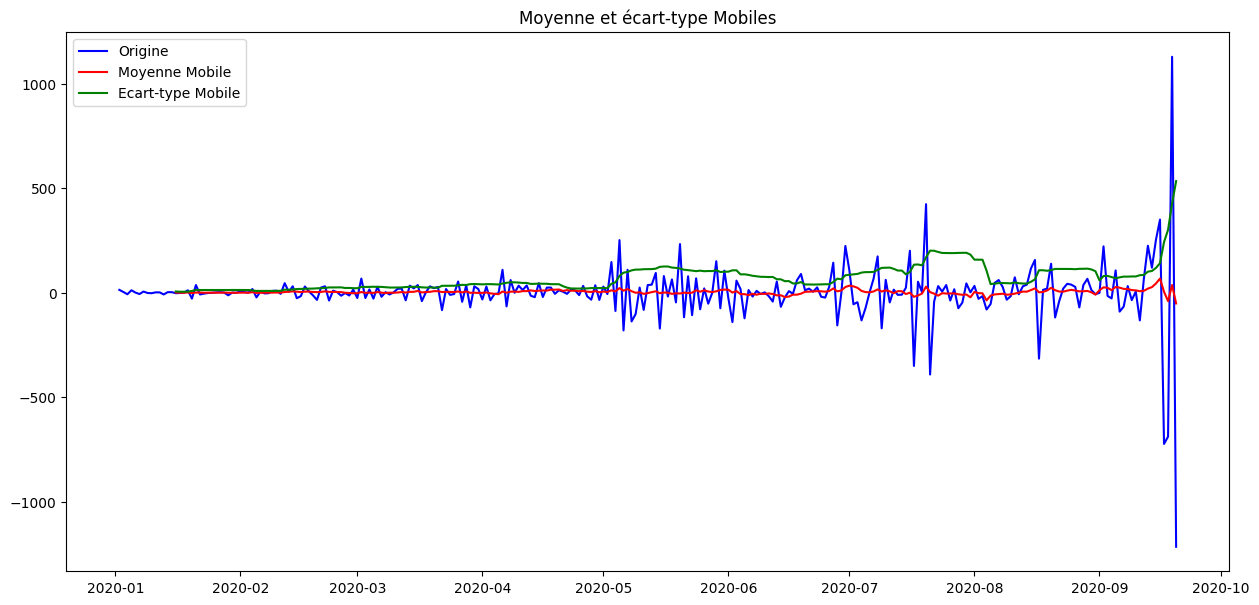

Statistiques ADF : -4.539852730267229
p-value : 0.00016648339090879642
Valeurs Critiques :
	1%: -3.457105309726321
	5%: -2.873313676101283
	10%: -2.5730443824681606


In [100]:
var_diff_1 = data_to_work.clicks-data_to_work.clicks.shift(1)
var_diff_1.dropna(inplace=True)
get_stationarity(var_diff_1)

Yes, here the serie seems to be stationnary. p-value < 5% and ADF is very very less than the critical values

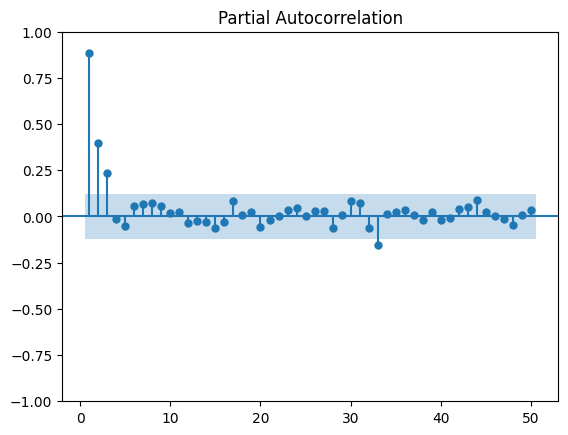

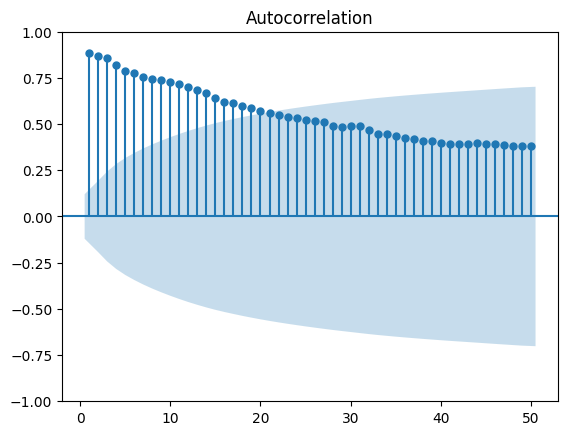

In [101]:
plot_pacf(data_to_work.clicks, lags=50, zero=False);
plot_acf(data_to_work.clicks, lags=50, zero=False);

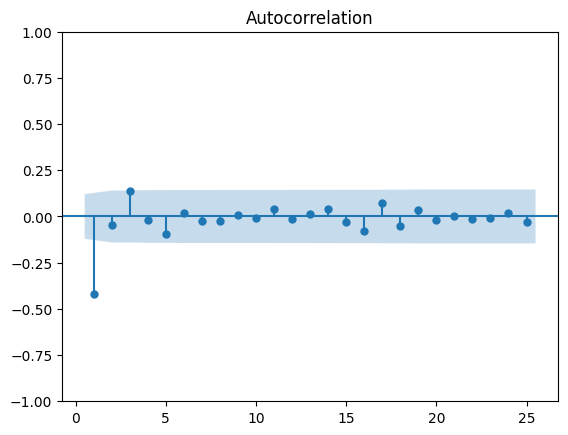

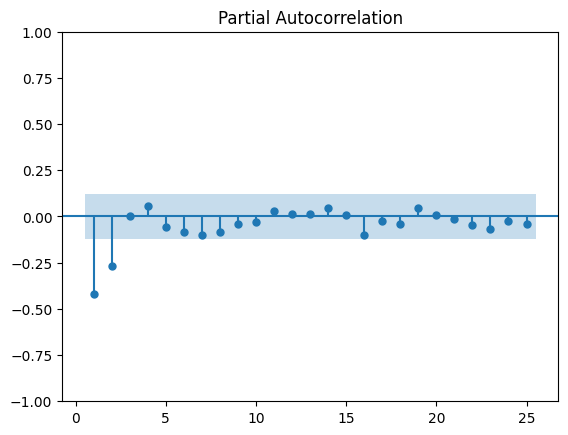

In [102]:
plot_acf(var_diff_1,  zero=False);
plot_pacf(var_diff_1, zero=False);

From ACF, we can see the lag is decreasing and going to 0. The serie seems to be stationnary

In [103]:
data_to_work_numerics = data_to_work.select_dtypes("number")

In [104]:
data_to_work_numerics.corr().style.background_gradient()

,clicks,impressions,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
clicks,1.000000,0.979210,-0.579964,0.262589,0.579786
impressions,0.979210,1.000000,-0.672910,0.210604,0.670746
EXPANDED_TEXT_AD,-0.579964,-0.672910,1.000000,0.071067,-0.987450
EXPANDED_DYNAMIC_SEARCH_AD,0.262589,0.210604,0.071067,1.000000,-0.067564
RESPONSIVE_SEARCH_AD,0.579786,0.670746,-0.987450,-0.067564,1.000000


In [105]:
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(data_to_work_numerics.drop(columns="clicks").values, i) for i in range(len(data_to_work_numerics.drop(columns="clicks").columns))]
vif_data["Feature Name"] = data_to_work_numerics.drop(columns="clicks").columns
vif_data

,VIF,Feature Name
0,5.277006,impressions
1,9.876469,EXPANDED_TEXT_AD
2,13.537884,EXPANDED_DYNAMIC_SEARCH_AD
3,3.970924,RESPONSIVE_SEARCH_AD


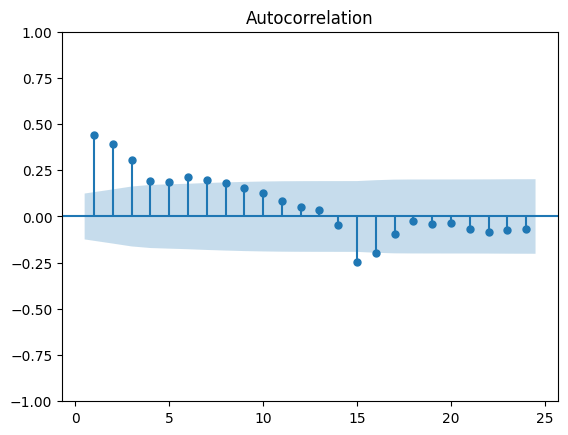

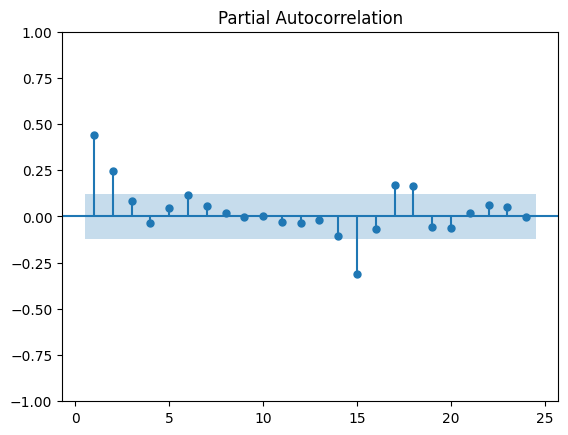

In [106]:
z = data_to_work.clicks - data_to_work.clicks.shift(15)
z.dropna(inplace=True)
plot_acf(z, zero=False);
plot_pacf(z, zero=False);

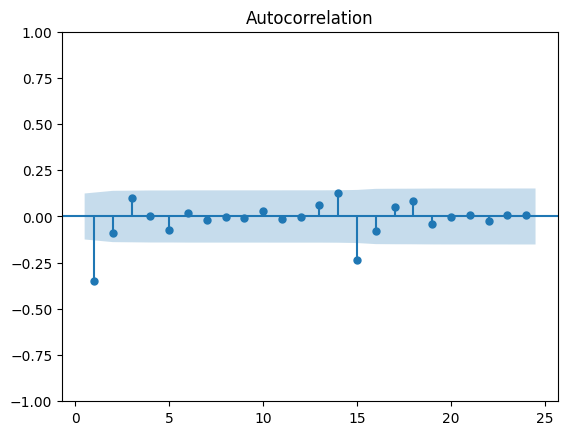

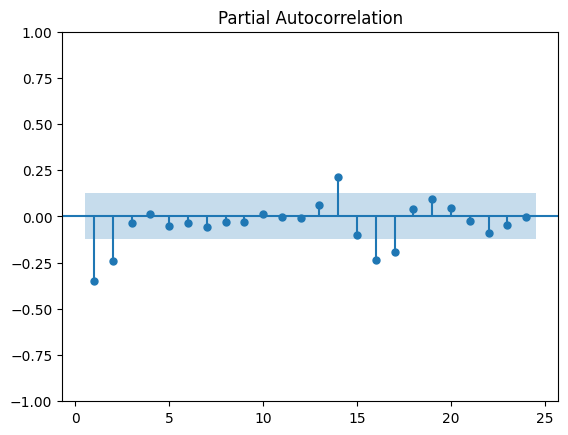

In [107]:
z1 = z - z.shift(1)
z1.dropna(inplace=True)
plot_acf(z1, zero=False);
plot_pacf(z1, zero=False);

<code> When the autocorrelation is not decreasing to 0. So it's stationnary. We don't need to differentiate it.

We would have done it if it was non stationnary. 

Whatever would be readen elsewhere, this is the thing to keep in mind</code> 

In [108]:
target = "clicks"
X = data_to_work.drop(target, axis =1)
#X"EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = X[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].astype(int) 
y = np.log(data_to_work[target])

In [109]:
display(X.head(), y.head())

,impressions,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,
2020-01-01,393.0,1,0,0
2020-01-02,395.0,1,0,0
2020-01-03,404.0,1,0,0
2020-01-04,476.0,1,0,0
2020-01-05,466.0,1,0,0


date
2020-01-01    3.583519
2020-01-02    3.912023
2020-01-03    3.988984
2020-01-04    3.850148
2020-01-05    4.077537
Freq: D, Name: clicks, dtype: float64

In [110]:
model_1 = SARIMAX(y, X, order=(1,1,1), seasonal_order=(0,1,1,15), simple_differencing=False, freq="D").fit(disp=False)
print(model_1.summary())

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             clicks   No. Observations:                  264
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 15)   Log Likelihood                 151.556
Date:                            Sun, 05 May 2024   AIC                           -287.112
Time:                                    10:31:33   BIC                           -259.005
Sample:                                01-01-2020   HQIC                          -275.797
                                     - 09-20-2020                                         
Covariance Type:                              opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
impressions                 9.391e-05    8.6e-06     10.914      0.000     7.7e-05

In [111]:
#model_2 = SARIMAX(y, X, order=(1,1,1), seasonal_order=(0,1,0,7), simple_differencing=False, freq="D").fit(disp=False)
#print(model_2.summary())

In [112]:
def optimize_ARIMA(endog, exog, order_list, seasonal_order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in order_list:
        for seasonal_order in seasonal_order_list:    
            try: 
                model = SARIMAX(endog, exog, order=order, seasonal_order = seasonal_order, simple_differencing=False, freq="D").fit(disp=False)
            except:
                continue
                
            #aic = model.aic
            results.append([order, seasonal_order, model.aic, model.bic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', "P, D, Q", 'AIC', "BIC"]
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [125]:
from itertools import product

ps = range(1, 3, 1)
d = 1
qs = range(0, 2, 1)

Ps = range(0, 6, 1)
D=1
Qs = range(0,2,1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

seasonal_parameters = product(Ps, Qs)
seasonal_parameters_list = list(seasonal_parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

seasonal_order_list = []


for each in seasonal_parameters_list:
    each = list(each)
    each.append(15)
    each.insert(1, D)
    each = tuple(each)
    seasonal_order_list.append(each)

order_list[:10], seasonal_order_list

([(1, 1, 0), (1, 1, 1), (2, 1, 0), (2, 1, 1)],
 [(0, 1, 0, 15),
  (0, 1, 1, 15),
  (4, 1, 0, 15),
  (4, 1, 1, 15),
  (8, 1, 0, 15),
  (8, 1, 1, 15),
  (12, 1, 0, 15),
  (12, 1, 1, 15),
  (16, 1, 0, 15),
  (16, 1, 1, 15)])

In [126]:
result_df = optimize_ARIMA(y,X, order_list, seasonal_order_list)
result_df

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary startin

,"(p, d, q)","P, D, Q",AIC,BIC
0,"(2, 1, 1)","(0, 1, 1, 15)",-287.178469,-255.557610
1,"(1, 1, 1)","(0, 1, 1, 15)",-287.112225,-259.004795
2,"(2, 1, 1)","(4, 1, 0, 15)",-282.103229,-239.942084
3,"(1, 1, 1)","(4, 1, 0, 15)",-281.970312,-243.322596
4,"(2, 1, 0)","(0, 1, 1, 15)",-279.356126,-251.248696
5,"(2, 1, 1)","(4, 1, 1, 15)",-278.588809,-232.914236
6,"(1, 1, 1)","(4, 1, 1, 15)",-278.416102,-236.254957
7,"(1, 1, 0)","(0, 1, 1, 15)",-277.121036,-252.527034
8,"(2, 1, 0)","(4, 1, 0, 15)",-274.184717,-235.537001
9,"(1, 1, 0)","(4, 1, 0, 15)",-271.518374,-236.384086


In [127]:
result_df.sort_values(by="BIC")

,"(p, d, q)","P, D, Q",AIC,BIC
1,"(1, 1, 1)","(0, 1, 1, 15)",-287.112225,-259.004795
0,"(2, 1, 1)","(0, 1, 1, 15)",-287.178469,-255.557610
7,"(1, 1, 0)","(0, 1, 1, 15)",-277.121036,-252.527034
4,"(2, 1, 0)","(0, 1, 1, 15)",-279.356126,-251.248696
3,"(1, 1, 1)","(4, 1, 0, 15)",-281.970312,-243.322596
2,"(2, 1, 1)","(4, 1, 0, 15)",-282.103229,-239.942084
9,"(1, 1, 0)","(4, 1, 0, 15)",-271.518374,-236.384086
6,"(1, 1, 1)","(4, 1, 1, 15)",-278.416102,-236.254957
8,"(2, 1, 0)","(4, 1, 0, 15)",-274.184717,-235.537001
5,"(2, 1, 1)","(4, 1, 1, 15)",-278.588809,-232.914236


## Good model

                                      SARIMAX Results                                      
Dep. Variable:                              clicks   No. Observations:                  264
Model:             SARIMAX(2, 1, 1)x(8, 1, [], 15)   Log Likelihood                 150.962
Date:                             Sun, 05 May 2024   AIC                           -269.925
Time:                                     16:46:08   BIC                           -213.710
Sample:                                 01-01-2020   HQIC                          -247.295
                                      - 09-20-2020                                         
Covariance Type:                               opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
impressions                 9.312e-05   9.69e-06      9.614      0.000    

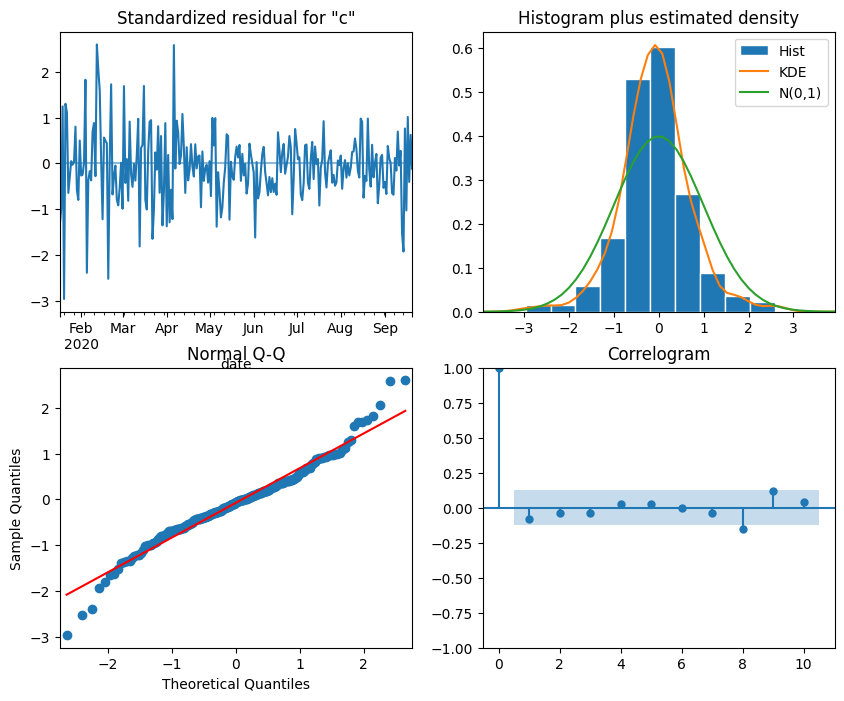

In [143]:
good_model = SARIMAX(endog=y, exog=X, order=(2,1,1), seasonal_order=(8,1,0,15),simple_differencing=False, freq="D").fit(disp=False)
print(good_model.summary())
good_model.plot_diagnostics(figsize=(10, 8));

In [145]:
good_model = SARIMAX(endog=y, exog=X, order=(1,1,0), seasonal_order=(0,1,1,15),simple_differencing=False, freq="D").fit(disp=False)
print(good_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               clicks   No. Observations:                  264
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 15)   Log Likelihood                 145.561
Date:                              Sun, 05 May 2024   AIC                           -277.121
Time:                                      16:46:42   BIC                           -252.527
Sample:                                  01-01-2020   HQIC                          -267.220
                                       - 09-20-2020                                         
Covariance Type:                                opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
impressions                 9.349e-05   9.51e-06      9.828      0

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [147]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print('Retard : p-value')
for lag in [15, 30, 45, 60]:
    print('{} : {}'.format(lag, acorr_ljungbox(good_model.resid, lags=lag, return_df=False)["lb_pvalue"].mean()))

Retard : p-value
15 : 0.6774823323840821
30 : 0.33893712198352616
45 : 0.22859837030548485
60 : 0.1811178766861959


In [150]:
from scipy.stats import shapiro
shapiro(good_model.resid)

ShapiroResult(statistic=0.45783926122321295, pvalue=1.4498778056965352e-27)

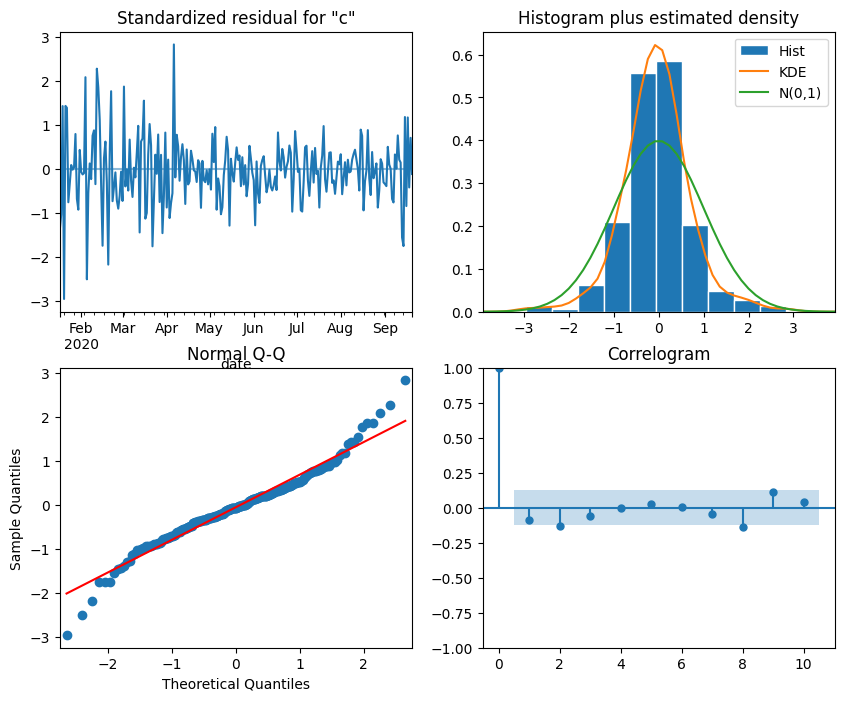

In [151]:
good_model.plot_diagnostics(figsize=(10, 8));

In [97]:
#good_model = SARIMAX(endog=y, exog=X, order=(3,0,2), simple_differencing=False, freq="D").fit(disp=False)
#print(good_model.summary())

In [154]:
y_pred_wfv = pd.Series()
history = y.copy()
for i in range(14):
    model = SARIMAX(history, order=(1,1,0), seasonal_order=(0,1,1,15)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

AttributeError: 'Series' object has no attribute 'append'

In [156]:
# Generate dummy exogenous variables for the next 14 days
dummy_exog = np.zeros((14, X.shape[1]))  # Assuming X is the exogenous variable data

# Forecast for the next 14 days with dummy exogenous variables
forecast_results = good_model.forecast(steps=14, exog=dummy_exog)

# Display the forecasted values
print("Forecasted values for the next 14 days:")
print(forecast_results)

Forecasted values for the next 14 days:
2020-09-21    5.497408
2020-09-22    5.496889
2020-09-23    5.502214
2020-09-24    5.510861
2020-09-25    5.543169
2020-09-26    5.515630
2020-09-27    5.486162
2020-09-28    5.462401
2020-09-29    5.478944
2020-09-30    5.516316
2020-10-01    5.414945
2020-10-02    5.507423
2020-10-03    5.467100
2020-10-04    5.536949
Freq: D, Name: predicted_mean, dtype: float64


In [164]:
# Generate dummy exogenous variables for the next 14 days
dummy_exog = np.zeros((14, X.shape[1]))  # Assuming X is the exogenous variable data

# Forecast for the next 14 days with dummy exogenous variables
forecast_results = good_model.forecast(steps=14, exog=dummy_exog)

# Display the forecasted values
print("Forecasted values for the next 14 days:")
print(forecast_results)

# Extract and display the top 5 features for each prediction
for i in range(14):  # Assuming you have 14 days forecasted
    # Assuming you have coefficients or some other way to identify top features
    top_features_indices = np.argsort(np.abs(good_model.params))[-5:]
    top_features_names = [X.columns[i] for i in top_features_indices if i < len(X.columns)]
    print(f"Top 5 features for day {i+1}: {top_features_names}")


Forecasted values for the next 14 days:
2020-09-21    5.497408
2020-09-22    5.496889
2020-09-23    5.502214
2020-09-24    5.510861
2020-09-25    5.543169
2020-09-26    5.515630
2020-09-27    5.486162
2020-09-28    5.462401
2020-09-29    5.478944
2020-09-30    5.516316
2020-10-01    5.414945
2020-10-02    5.507423
2020-10-03    5.467100
2020-10-04    5.536949
Freq: D, Name: predicted_mean, dtype: float64
Top 5 features for day 1: ['EXPANDED_DYNAMIC_SEARCH_AD', 'EXPANDED_TEXT_AD']
Top 5 features for day 2: ['EXPANDED_DYNAMIC_SEARCH_AD', 'EXPANDED_TEXT_AD']
Top 5 features for day 3: ['EXPANDED_DYNAMIC_SEARCH_AD', 'EXPANDED_TEXT_AD']
Top 5 features for day 4: ['EXPANDED_DYNAMIC_SEARCH_AD', 'EXPANDED_TEXT_AD']
Top 5 features for day 5: ['EXPANDED_DYNAMIC_SEARCH_AD', 'EXPANDED_TEXT_AD']
Top 5 features for day 6: ['EXPANDED_DYNAMIC_SEARCH_AD', 'EXPANDED_TEXT_AD']
Top 5 features for day 7: ['EXPANDED_DYNAMIC_SEARCH_AD', 'EXPANDED_TEXT_AD']
Top 5 features for day 8: ['EXPANDED_DYNAMIC_SEARCH_A

In [161]:
import numpy as np

# Nombre de jours dans chaque semaine
jours_par_semaine = 7

# Effectuer les prédictions pour les deux prochaines semaines sans exogènes
forecast_results = good_model.forecast(steps=2 * jours_par_semaine, exog = np.zeros((14, X.shape[1])))

# Calculer la somme des prédictions pour chaque semaine
weekly_predictions = []
for semaine in range(0, 2):
    debut_semaine = semaine * jours_par_semaine
    fin_semaine = (semaine + 1) * jours_par_semaine
    prediction_semaine = np.sum(forecast_results[debut_semaine:fin_semaine])
    weekly_predictions.append(prediction_semaine)

# Identifier les cinq fonctionnalités les plus impactantes pour chaque semaine
top_features = []
for semaine in range(0, 2):
    debut_semaine = semaine * jours_par_semaine
    fin_semaine = (semaine + 1) * jours_par_semaine
    semaine_results = good_model.get_prediction(start=debut_semaine, end=fin_semaine).summary_frame()
    semaine_top_features = semaine_results.abs().mean().sort_values(ascending=False).index[:5]
    top_features.append(semaine_top_features)

# Afficher les résultats
print("Prédictions hebdomadaires pour les deux prochaines semaines:")
print(weekly_predictions)
print("Cinq fonctionnalités les plus impactantes pour chaque prédiction de chaque semaine:")
for semaine, features in enumerate(top_features):
    print("Semaine", semaine + 1, ":", features.tolist())


Prédictions hebdomadaires pour les deux prochaines semaines:
[38.55233269447713, 38.38407866030306]
Cinq fonctionnalités les plus impactantes pour chaque prédiction de chaque semaine:
Semaine 1 : ['mean_ci_upper', 'mean_ci_lower', 'mean_se', 'mean']
Semaine 2 : ['mean_ci_upper', 'mean_ci_lower', 'mean_se', 'mean']
